In [1]:
# Load libraries.

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

import seaborn as sns

import datetime
import re

import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

# Setting baseline seed
np.random.seed(230204)

# Set print options.

np.set_printoptions(precision = 3)

plt.style.use("ggplot")

mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "grey"
mpl.rcParams["grid.alpha"] = 0.25

mpl.rcParams["axes.facecolor"] = "white"

mpl.rcParams["legend.fontsize"] = 14

%matplotlib inline

In [2]:
import pkg_resources

In [3]:
import cvxopt as opt
from cvxopt import blas, solvers

In [5]:
import sklearn

In [6]:
from pandas import read_csv, set_option

In [7]:
dataset =\
    read_csv("https://talktoroh.squarespace.com/s/sp500_hrp.csv",
             index_col = 0)

In [9]:
dataset.isnull().values.any()

True

In [14]:
missing_frac = dataset.isnull().mean().sort_values(ascending=False)
missing_frac.head(7)

CTVA    0.781250
DOW     0.678571
FOX     0.667411
FOXA    0.665179
NOV     0.000000
MSI     0.000000
MSCI    0.000000
dtype: float64

In [17]:
list_to_drop =\
    sorted(list(missing_frac
                [missing_frac > 0.30]
                .index)
          )

In [18]:
dataset =\
(
    dataset
    .drop(labels = list_to_drop,
          axis = 1)
)

In [19]:
dataset =\
(
    dataset
    .fillna(method = "ffill")
)

dataset.head(3)

,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,AMG,...,WLTW,WYNN,XEL,XRX,XLNX,XYL,YUM,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,58.790001,98.410004,192.490005,153.839996,64.309998,177.699997,10.98,106.089996,10.88,203.039993,...,146.990005,164.300003,47.810001,29.370001,67.879997,68.070000,81.599998,124.059998,50.700001,71.769997
2018-01-03,58.919998,99.949997,195.820007,154.550003,65.309998,181.039993,11.55,107.050003,10.87,202.119995,...,149.740005,162.520004,47.490002,29.330000,69.239998,68.900002,81.529999,124.919998,50.639999,72.099998
2018-01-04,58.820000,99.379997,199.250000,156.380005,64.660004,183.220001,12.12,111.000000,10.83,198.539993,...,151.259995,163.399994,47.119999,29.690001,70.489998,69.360001,82.360001,124.739998,50.849998,72.529999


In [21]:
X = dataset.copy("deep")

row = len(X)

train_len = int(row * 0.80)

In [22]:
X_train = X.head(train_len)

X_test = X.tail(row - train_len)

In [23]:
returns = X_train.pct_change().dropna()

returns_test = X_test.pct_change().dropna()

In [24]:
# For HRP

from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.cluster.hierarchy import fcluster

from sklearn.preprocessing import StandardScaler

from sklearn import cluster, covariance, manifold
from sklearn.metrics import adjusted_mutual_info_score

from sklearn.cluster import AgglomerativeClustering # AGglomerative NESting

import scipy.cluster.hierarchy as sch

In [25]:
def correlation_distance(corr):
   # Compute the distance matrix from the correlation matrix
   # The values in the distance matrix range between 0 and 1. 
    dist = ((1 - corr) / 2.0) ** 0.5
    
    return dist

In [180]:
dist =\
    correlation_distance(returns
                         .corr()
                         )

link =\
    linkage(dist,
            "ward")

link[5]

array([6.100e+01, 4.470e+02, 3.371e-01, 2.000e+00])

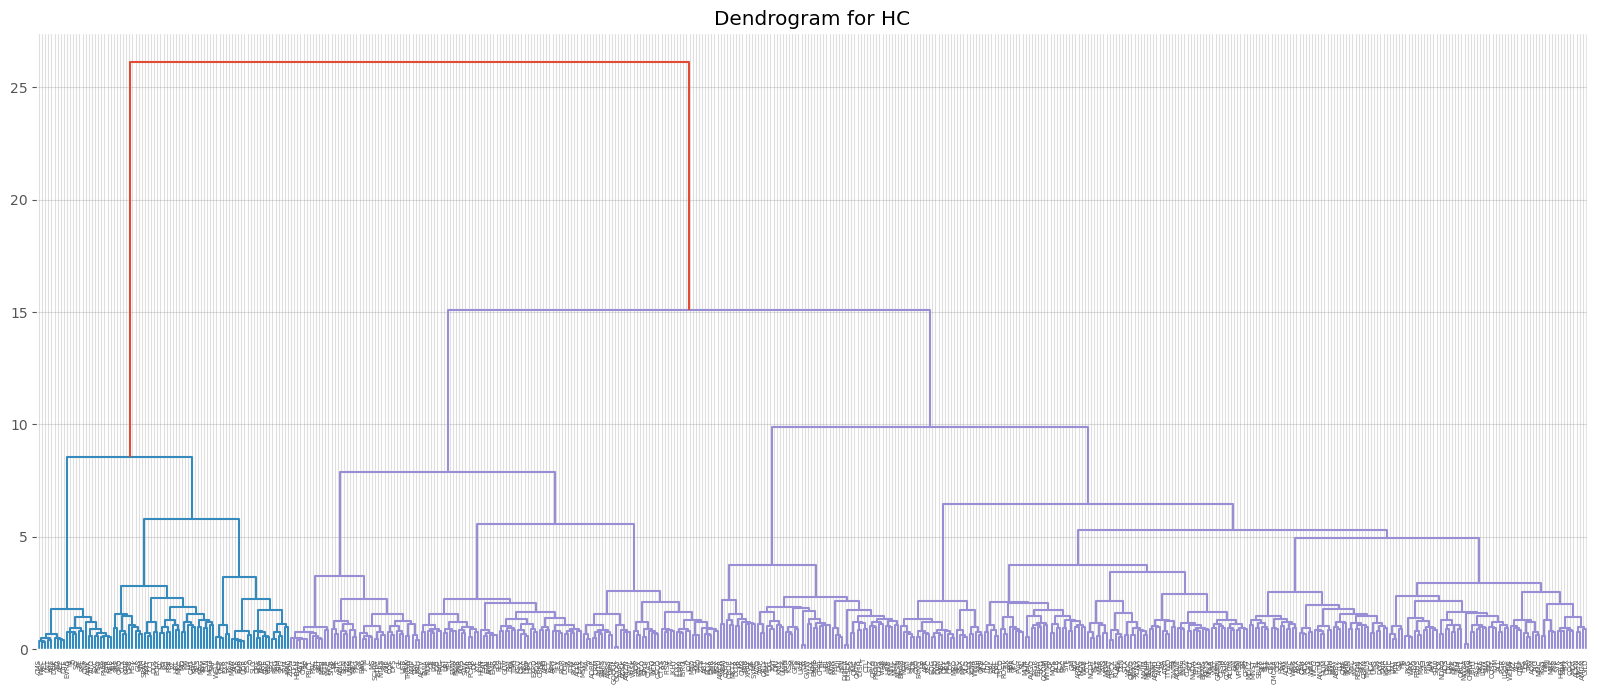

In [33]:
# Visualize HC

plt.figure(figsize = [20, 8]
          )

plt.title("Dendrogram for HC")

dendrogram(link,
           labels = X.columns)

plt.show()

In [118]:
def QuasiDiag(link):

    # Convert the linkage matrix to integer type.    
    link = link.astype(int)

    # Initialize with the last merged cluster.
    sorted_index =\
        pd \
        .Series([link[-1,0], link[-1, 1]
                ]
               )

    # Get the total number of original items/clusters.
    num_items = link[-1, 3] # please input original items here

    # Keep going until all items are separated.
    while sorted_index.max() >= num_items:

        # Create space for the new cluster items.
  
        sorted_index.index = range(0, sorted_index.shape[0] * 2, 2) # obtain space

        # Identify the clusters that need further breaking down.
        
        df_0 = sorted_index[sorted_index >= num_items] # search for clusters

        # Extract corresponding rows from the linkage matrix.
        
        i = df_0.index
        j = df_0.values - num_items

        # Replace the cluster with its two child items (from the linkage matrix).
        
        sorted_index[i] = link[j, 0] # your first item

        # Create a new series for the second child item.
        
        df_0 = pd.Series(link[j, 1], index=i + 1)
        
        # Concatenate the two series.
        sorted_index =\
            pd \
            .concat([sorted_index, 
                     df_0]
                   )
        
        # Reorder the indices after concatenation.
        sorted_index = sorted_index.sort_index()
        sorted_index.index = range(sorted_index.shape[0]
                                  )
        
    return sorted_index.tolist()

In [181]:
def ClusterCov(cov, c_items):

    # Filter the covariance matrix to only include the assets in the cluster

    cov = cov.loc[c_items, c_items] # slicing your matrix

    # Calculate the Inverse Variance Portfolio (IVP) weights for the assets in the cluster
    # IVP(): a function that calculates the weights of assets in a portfolio based on the inverse of their variances, 
    
    w_ = IVP(cov).reshape(-1, 1)
        
    # Compute the covariance for the cluster using the formula: w^T * Cov * w
    
    covariance = np.dot(np.dot(w_.T,
                               cov),
                        w_)[0, 0]
    return covariance

In [182]:
def IVP(cov, **kargs):
    
    # Calculate the inverse of the diagonal of the covariance matrix.
    # This gives the inverse of the variances of individual assets.
    ivp = 1.0 / np.diag(cov)

    # Normalize the weights so they sum up to 1.
    ivp /= ivp.sum()
    
    return ivp

In [183]:
# Calcuate HRP allocation

def RecursiveBis(cov, sorted_index):

    # Initialize weights for all assets to 1
    
    w = pd.Series(1, 
                  index = sorted_index)

    # Start with all assets in one cluster
    
    c_items = [sorted_index] # this is where we initialize all items in a single cluster

    # Continue bisecting until all assets are in their own cluster
    
    while len(c_items) > 0:

        # Split each cluster into two sub-clusters

        c_items = [i[j:k] for i in c_items for j, k in ((0, len(i) // 2), (len(i) // 2, len(i))) if len(i) > 1] # bi-section

        # Iterate over pairs of sub-clusters

        for i in range(0, len(c_items), 2): # tease out pairs

            # Extract the pair of sub-clusters 
            c_items_0 = c_items[i] # first cluster
            c_items_1 = c_items[i + 1] # second cluster

            # Compute the covariance for each sub-cluster
            covariance_0 = ClusterCov(cov, c_items_0)
            covariance_1 = ClusterCov(cov, c_items_1)

            # Compute the weight for assets in the first sub-cluster

            alpha = 1 - covariance_0 / (covariance_0 + covariance_1)

            # Update the weights for assets in both sub-clusters

            w[c_items_0] *= alpha # weight #1
            w[c_items_1] *= 1 - alpha # weight # 2
    
    return w

In [184]:
def MVP(cov):

    # Convert the covariance matrix to a numpy array.
    
    cov = cov.T.values
    n = len(cov)

    # Define a range of expected returns to compute the efficient frontier.

    N = 100
    mus = [10 ** (5.0 * t / N - 1.0) for t in range(N)]

    # Set up matrices for quadratic programming.
  
    S = opt.matrix(cov)
    pbar = opt.matrix(np.ones(cov.shape[0]
                             )
                     )
    
    # Inequality constraints (all asset weights should be non-negative).
    # Build contraint matrices   
    G = -opt.matrix(np.eye(n)) # NEGATIVE n x n (identity) matrix
  
    h = opt.matrix(0.0, (n, 1)
                  )

    # Equality constraints (sum of weights should be 1).    
    A = opt.matrix(1.0, (1, n)
                  )
    
    b = opt.matrix(1.0)
      
    # Calculate the efficient frontier by solving the QP problem for each target return in 'mus'.
    
    solvers.options["show_progress"] = False
    
    portfolios = [solvers.qp(mu * S, -pbar, G, h, A, b)["x"] for mu in mus]

    # Calculate risks and returns for each portfolio on the efficient frontier.
    
    returns = [blas.dot(pbar, x) for x in portfolios]
    
    risks = [np.sqrt(blas.dot(x, S * x)) for x in portfolios]

    # Fit a quadratic function to the risks and returns to find the minimum risk portfolio.
    
    m_1 = np.polyfit(returns, risks, 2)
    
    x_1 = np.sqrt(m_1[2] / m_1[0]
                 )
    
    # Solve the QP problem one last time to find the MVP using the optimal risk-return trade-off.
    
    wt = solvers.qp(opt.matrix(x_1 * S), -pbar, G, h, A, b)["x"]
    
    return list(wt)

In [185]:
def HRP(cov, corr):

    # Convert the correlation matrix into a distance matrix.
    
    dist = correlation_distance(corr)

    # Perform hierarchical clustering to identify clusters of similar assets.

    link = sch.linkage(dist,
                       "single")

    # Use the QuasiDiag function to order assets based on the linkage matrix.
    # This will result in a reordering of the assets based on their hierarchical structure.
    
    sorted_index = QuasiDiag(link)

    # Convert numerical indices back to asset names.
    
    sorted_index = corr.index[sorted_index].tolist()

    # Use the RecursiveBis function to allocate capital among assets 
    # based on the hierarchical structure and their individual risks.
    
    hrp = RecursiveBis(cov, sorted_index)

    # Return the portfolio weights sorted by asset names.
    
    return hrp.sort_index()

In [186]:
def obtain_all_portfolios(returns):

    # Calculate the covariance and correlation matrices from the returns.
    
    cov, corr = returns.cov(), returns.corr()

    # Calculate HRP portfolio weights.
    
    hrp = HRP(cov, corr)

    # Calculate MVP portfolio weights.
    
    mvp = MVP(cov)

    # Convert the MVP weights to a pandas Series for easier manipulation.
    
    mvp = pd.Series(mvp,
                    index = cov.index)

    # Combine the MVP and HRP portfolio weights into a single DataFrame.
    
    portfolios = pd.DataFrame([mvp, hrp],
                              index = ["MVP", "HRP"]
                             ).T
    
    return portfolios

In [187]:
portfolios = obtain_all_portfolios(returns)

Text(0.5, 1.0, 'HRP')

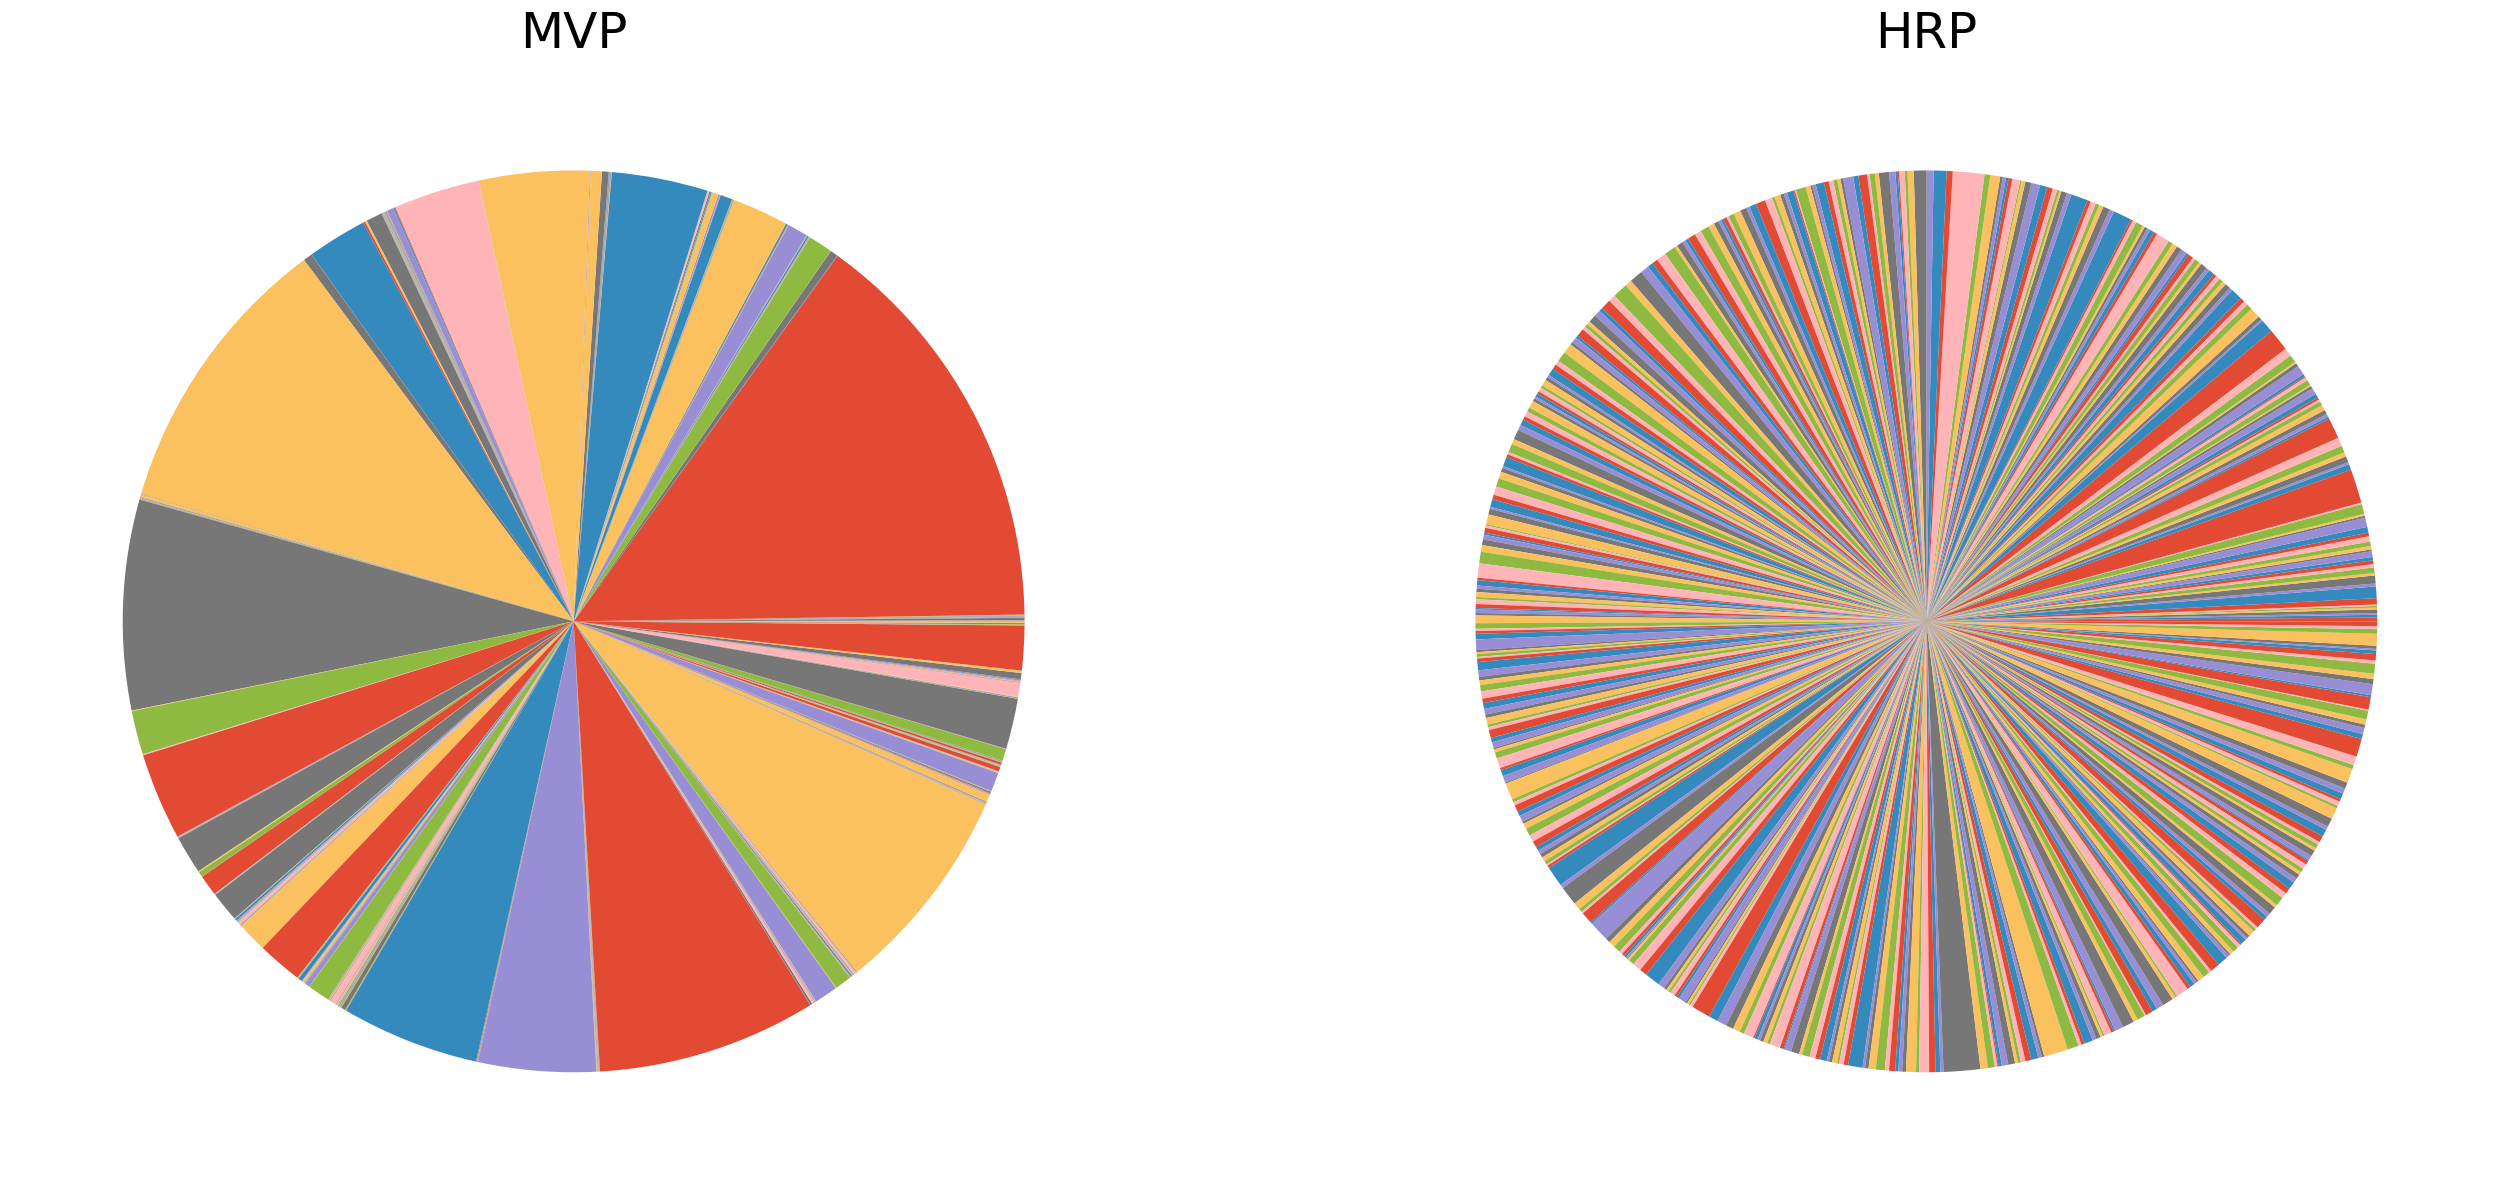

In [188]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [32, 24]
                              )

ax1.pie(portfolios.iloc[: , 0] );
ax1.set_title("MVP",
              fontsize = 36)

ax2.pie(portfolios.iloc[: , 1] );
ax2.set_title("HRP",
              fontsize = 36)


In [189]:
in_sample =\
(
    pd
    .DataFrame(np.dot(returns,
                      np.array(portfolios)
                     ),
               index = returns.index,
               columns = ["MVP", "HRP"]
              )
)

In [190]:
in_sample

,MVP,HRP
Date,,
2018-01-03,-0.001428,0.003571
2018-01-04,0.001971,0.002121
2018-01-05,0.002549,0.005086
2018-01-08,0.002785,0.003095
2018-01-09,-0.002608,-0.001173
...,...,...
2019-05-30,0.003343,0.002259
2019-05-31,-0.002298,-0.007682
2019-06-03,0.005667,0.007275


In [191]:
out_of_sample =\
    (
    pd
    .DataFrame(np.dot(returns_test,
                      np.array(portfolios)
                     ),
               index = returns_test.index,
               columns = ["MVP", "HRP"]
              )
)

In [192]:
out_of_sample

,MVP,HRP
Date,,
2019-06-07,0.004532,0.005991
2019-06-10,-0.002820,0.001371
2019-06-11,-0.005168,-0.001648
2019-06-12,0.005354,0.000915
2019-06-13,-0.002804,0.003690
...,...,...
2019-10-07,-0.003645,-0.005026
2019-10-08,-0.008607,-0.015016
2019-10-09,0.005037,0.007286


<Axes: title={'center': 'Out-of-Sample Results'}, xlabel='Date'>

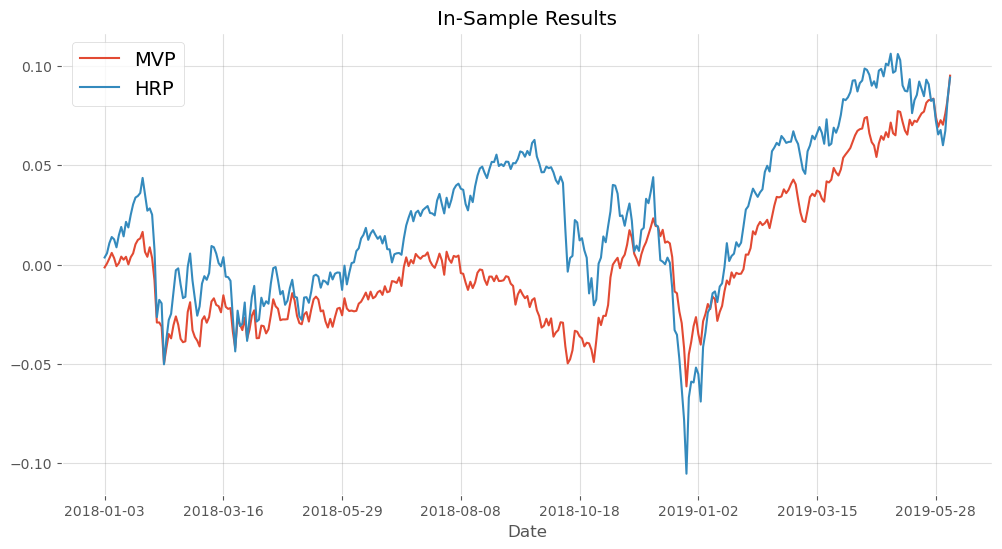

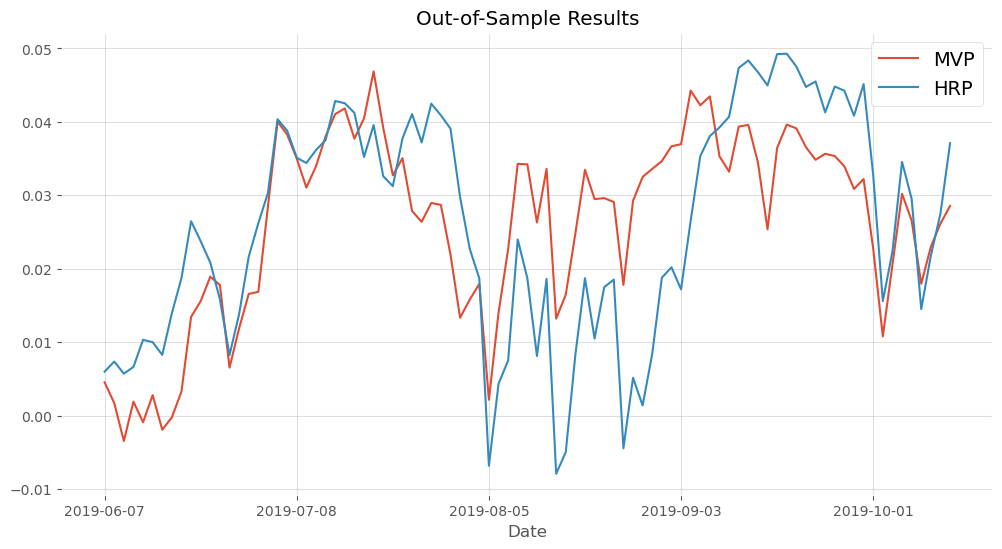

In [193]:
in_sample.cumsum().plot(figsize = [12, 6],
                        title = "In-Sample Results"
                       )

out_of_sample.cumsum().plot(figsize = [12, 6],
                            title = "Out-of-Sample Results"
                            )

In [194]:
Volatility = in_sample.std() * np.sqrt(252)

Sharpe = (in_sample.mean()*np.sqrt(252)) / in_sample.std()

in_sample_performance =\
    (pd
     .DataFrame(dict(Volatility = Volatility,
                     Sharpe_Ratio = Sharpe)
               )
    )

in_sample_performance

,Volatility,Sharpe_Ratio
MVP,0.085516,0.785019
HRP,0.126944,0.523599


In [195]:
# Team, we are interested in out-of-sample

out_of_sample_Volatility = out_of_sample.std() * np.sqrt(252)

out_of_sample_Sharpe = (out_of_sample.mean()*np.sqrt(252)) / out_of_sample.std()

out_of_sample_performance =\
    (pd
     .DataFrame(dict(Volatility = out_of_sample_Volatility,
                     Sharpe_Ratio = out_of_sample_Sharpe)
               )
    )

out_of_sample_performance

,Volatility,Sharpe_Ratio
MVP,0.102761,0.786621
HRP,0.125610,0.836159
